## Project 5: WAM News Prediction of  California's Gubernatorial 2021 Election

### Import Libraries

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

### Load Data

In [3]:
# read data
df=pd.read_csv('./data/2018_gov_features.csv', index_col=0)
df.head()

,dist,ownhome,pid3,gender,age,educ,race,faminc,marstat,newsint,approval_gov,ideo5,voted_gov
392782,19,Other,Democrat,Female,54,4-Year,White,50k - 60k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1]
392786,52,Rent,Democrat,Female,28,Some College,White,20k - 30k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1]
392800,49,Own,Other,Male,86,Post-Grad,White,120k - 150k,Widowed,Most of the time,Strongly Disapprove,Very Conservative,[Republican / Candidate 2]
392832,36,Own,Republican,Male,80,Some College,White,20k - 30k,Widowed,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2]
392860,36,Own,Independent,Male,83,4-Year,White,Prefer not to say,Married,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2]


In [4]:
df.shape

(3739, 13)

In [5]:
# check null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3739 entries, 392782 to 452724
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dist          3739 non-null   int64 
 1   ownhome       3739 non-null   object
 2   pid3          3739 non-null   object
 3   gender        3739 non-null   object
 4   age           3739 non-null   int64 
 5   educ          3739 non-null   object
 6   race          3739 non-null   object
 7   faminc        3739 non-null   object
 8   marstat       3739 non-null   object
 9   newsint       3739 non-null   object
 10  approval_gov  3739 non-null   object
 11  ideo5         3739 non-null   object
 12  voted_gov     3739 non-null   object
dtypes: int64(2), object(11)
memory usage: 409.0+ KB


In [6]:
# baseline accuracy
df['voted_gov'].value_counts(normalize=True)

[Democrat / Candidate 1]       0.611661
[Republican / Candidate 2]     0.368013
I Did Not Vote In This Race    0.009896
Not Sure                       0.006686
Other                          0.003744
Name: voted_gov, dtype: float64

Baseline accuracy is 61.2%. We have unimbalanced data.

In [7]:
# drop other categories, make it a binary classification
df = df[(df.voted_gov != 'I Did Not Vote In This Race') & (df.voted_gov != 'Not Sure') & (df.voted_gov != 'Other')]
df['voted_gov'].value_counts(normalize=True)

[Democrat / Candidate 1]      0.624352
[Republican / Candidate 2]    0.375648
Name: voted_gov, dtype: float64

In [8]:
# map voted_gov column to 0 and 1
df['voted_gov'] = df['voted_gov'].map({'[Democrat / Candidate 1]': 1, '[Republican / Candidate 2]': 0})
df.head()

,dist,ownhome,pid3,gender,age,educ,race,faminc,marstat,newsint,approval_gov,ideo5,voted_gov
392782,19,Other,Democrat,Female,54,4-Year,White,50k - 60k,Single / Never Married,Most of the time,Strongly Approve,Liberal,1
392786,52,Rent,Democrat,Female,28,Some College,White,20k - 30k,Single / Never Married,Most of the time,Strongly Approve,Liberal,1
392800,49,Own,Other,Male,86,Post-Grad,White,120k - 150k,Widowed,Most of the time,Strongly Disapprove,Very Conservative,0
392832,36,Own,Republican,Male,80,Some College,White,20k - 30k,Widowed,Most of the time,Strongly Disapprove,Conservative,0
392860,36,Own,Independent,Male,83,4-Year,White,Prefer not to say,Married,Most of the time,Strongly Disapprove,Conservative,0


In [9]:
# save cleaned data
df.to_csv('./data/2018_gov_clean1.csv')

## Pre-processing

In [10]:
# set up X and y
X = df.drop(columns =['voted_gov'])
y = df['voted_gov']

In [11]:
X= pd.get_dummies(X, drop_first=True)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

In [13]:
# check if shape of X = y
assert X.shape[0]==y.shape[0]

## Modeling

### 1. RandomForest

In [14]:
rf = RandomForestClassifier()

In [15]:
et = ExtraTreesClassifier()

In [16]:
# cross val score on train data
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.9250094386487829

In [17]:
# cross val score on train data
cross_val_score(et, X_train, y_train, cv=5).mean()

0.9250074515648287

In [18]:
rf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [19]:
# gridsearch 
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'max_features': ['sqrt', .5],
    'bootstrap': [True, False],
    'random_state': [42]
}

gs_rf = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
0.9264639841033284


{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 200,
 'random_state': 42}

In [20]:
# gridsearch optimization
print('best score:', gs_rf.best_score_)
print('best parameters:', gs_rf.best_params_)
print('accuracy on train data:', gs_rf.score(X_train, y_train))
print('accuracy on test data:', gs_rf.score(X_val, y_val))

best score: 0.9264639841033284
best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 42}
accuracy on train data: 1.0
accuracy on test data: 0.9344978165938864


In [21]:
# make predictions 
y_pred = gs_rf.predict(X_val)

# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

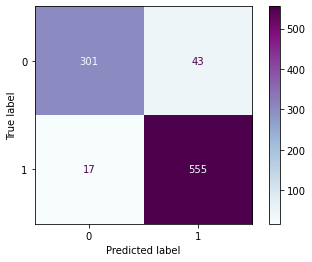

In [22]:
# plot a confusion matrix
plot_confusion_matrix(gs_rf, X_val, y_val, cmap='BuPu', values_format='d');

In [23]:
# metrics
accu = (tp+tn) / (tp+tn+fp+fn)
recall = tp/(tp+fn)
prec = tp/ (tp+fp)
spec= tn/(tn+fp)

print('Accuracy:', accu)
print('Recall:', recall)
print('Precision:', prec)
print('Specificity:', spec)

Accuracy: 0.9344978165938864
Recall: 0.9702797202797203
Precision: 0.9280936454849499
Specificity: 0.875


In [24]:
# classification report for the null model
print(classification_report(y_val, y_pred))

NameError: name 'classification_report' is not defined

- Random forest and extremely randomized trees performed pretty much the same on train data, random forest is slightly better. They performed better than null model accuracy of 62%. 
- Random forest model is overfit with 100% accuracy on train and 93.5% accuracy on test. It could be due to the grid search choosing maximum depth of 'None', which means the nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. Let's try another grid search without setting max_depth of 'None'.

In [ ]:
# get feature importances
pd.Series(gs_rf.best_estimator_.feature_importances_, X.columns).sort_values(ascending=False)

-  For a classfication random forest model, feature_importances_ is based on the average decrease in Gini impurity over the decision trees. 
- Strongly disapprove category of approval_gov feature has a 27.6% importance in the random forest model. For this variable, individuals were asked "Do you approve of the way each is doing their job". 
- pid3_Republican has a 17.9% importance.
- ideo5_Liberal has a 5.9% importance. 

In [ ]:
gs_rf.predict(X_val)[:10]

In [ ]:
pred = gs_rf.predict_proba(X_val)
pred[:10]

- The first array, [0, 1], corresponds to the first testing observation. - This first testing observation is predicted to have a 0% chance that  𝑌=0 and a 100% chance that  𝑌=1. The `.predict()` value for this observation is 1. This is because  𝑃(𝑌=1)>𝑃(𝑌=0).
- The fourth array, [0.795, 0.205], corresponds to the fourth testing observation. - This fourth testing observation is predicted to have a 79.5% chance that  𝑌=0 and a 20.5% chance that  𝑌=1. The `.predict()` value for this observation is 0. This is because  𝑃(𝑌=0)>𝑃(𝑌=1).

In [ ]:
class_weight

### 2. RandomForest 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

In [ ]:
rf_2 = RandomForestClassifier()

In [ ]:
cross_val_score(rf_2, X_train, y_train, cv=5).mean()

In [ ]:
# gridsearch 
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [1, 2, 3, 4, 5, 6],
    'max_features': ['sqrt', .5],
    'bootstrap': [True, False],
    'random_state': [42]
}

gs_rf = GridSearchCV(rf_2, rf_params, cv=5, n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

In [ ]:
# gridsearch optimization
print('best score:', gs_rf.best_score_)
print('best parameters:', gs_rf.best_params_)
print('accuracy on train data:', gs_rf.score(X_train, y_train))
print('accuracy on test data:', gs_rf.score(X_val, y_val))

In [ ]:
# make predictions 
y_pred = gs_rf.predict(X_val)

# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

In [ ]:
# plot a confusion matrix
plot_confusion_matrix(gs_rf, X_val, y_val, cmap='BuPu', values_format='d');

In [ ]:
# metrics
accu = (tp+tn) / (tp+tn+fp+fn)
recall = tp/(tp+fn)
prec = tp/ (tp+fp)
spec= tn/(tn+fp)

print('Accuracy:', accu)
print('Recall:', recall)
print('Precision:', prec)
print('Specificity:', spec)

Model has an accuracy of 93% on test and 92.6% on train. This model is not underfit or overfit, its in the sweet spot.

In [41]:
# get feature importances
pd.Series(gs_rf.best_estimator_.feature_importances_, X.columns).sort_values(ascending=False)

approval_gov_Strongly Disapprove                 0.276065
pid3_Republican                                  0.179077
ideo5_Liberal                                    0.062807
approval_gov_Strongly Approve                    0.051030
age                                              0.047006
ideo5_Very Liberal                               0.044914
dist                                             0.037558
ideo5_Very Conservative                          0.036985
pid3_Independent                                 0.023902
approval_gov_Disapprove / Somewhat Disapprove    0.020884
ideo5_Moderate                                   0.015640
race_White                                       0.012629
ownhome_Own                                      0.012001
gender_Male                                      0.010228
ownhome_Rent                                     0.009197
marstat_Single / Never Married                   0.009001
newsint_Most of the time                         0.008666
educ_4-Year   

- Strongly disapprove category of approval_gov feature has a 52.8% importance in the random forest model. 
- pid3_Republican has 22.2% and ideo5_Liberal has 4.4% importances.

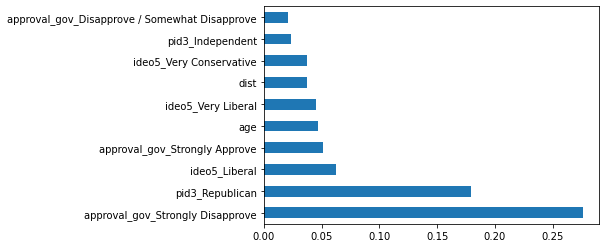

In [58]:
pd.Series(gs_rf.best_estimator_.feature_importances_, X_train.columns).sort_values(ascending=False)[:10].plot(kind='barh');

In [61]:
# get feature importances
importances= gs_rf.best_estimator_.feature_importances_

In [62]:
# get feature names
names=X_train.columns

In [68]:
# creates the feature importance dataframe
importance_dict = pd.DataFrame({'feature_importances': importances,
                                'features': names})
top10 = importance_dict.nlargest(10, columns=['feature_importances'])
top10

,feature_importances,features
45,0.276065,approval_gov_Strongly Disapprove
7,0.179077,pid3_Republican
46,0.062807,ideo5_Liberal
44,0.051030,approval_gov_Strongly Approve
1,0.047006,age
50,0.044914,ideo5_Very Liberal
0,0.037558,dist
49,0.036985,ideo5_Very Conservative
4,0.023902,pid3_Independent
42,0.020884,approval_gov_Disapprove / Somewhat Disapprove


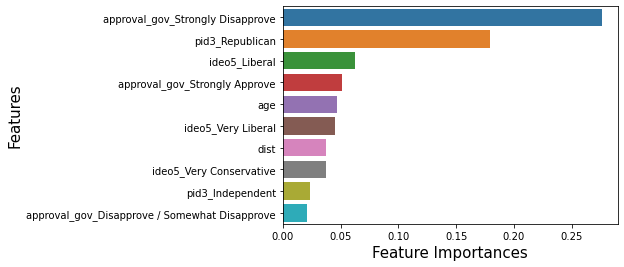

In [80]:
ax = sns.barplot(x="feature_importances", y="features", data=top10)

ax.set_xlabel('Feature Importances',fontsize=15);
ax.set_ylabel('Features',fontsize=15);
plt.show()

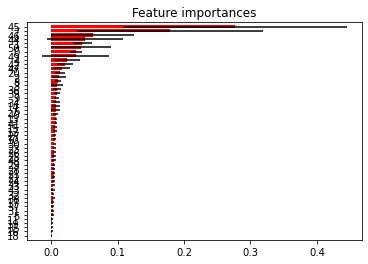

In [48]:
importances = gs_rf.best_estimator_.feature_importances_
indices = np.argsort(importances)
std = np.std([tree.feature_importances_ for tree in gs_rf.best_estimator_],
             axis=0)
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X.shape[1]), indices)
plt.ylim([-1, X.shape[1]])
plt.show()

In [43]:
df_test=pd.read_csv('./data/test_voters.csv', index_col=0)
df_test

,dist,age,ownhome_Own,ownhome_Rent,pid3_Independent,pid3_Not Sure,pid3_Other,pid3_Republican,gender_Male,educ_4-Year,...,newsint_Some of the time,approval_gov_Disapprove / Somewhat Disapprove,approval_gov_Never Heard / Not Sure,approval_gov_Strongly Approve,approval_gov_Strongly Disapprove,ideo5_Liberal,ideo5_Moderate,ideo5_Not Sure,ideo5_Very Conservative,ideo5_Very Liberal
470768,25,61,1,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
470779,30,86,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
470780,14,49,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
470781,49,63,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
470815,43,49,1,0,0,0,0,1,1,1,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531711,10,30,1,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
531715,4,31,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
531716,53,69,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
531725,52,44,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [93]:
df_new = pd.DataFrame(gs_rf.predict_proba(df_test))
df_new.mean()

0    0.312987
1    0.687013
dtype: float64

In [86]:
y_pred_test = gs_rf.predict(df_test)

In [ ]:
# make predictions 
y_pred = gs_rf.predict(X_val)

# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()